<a href="https://colab.research.google.com/github/kittisaktaoma/GO-tools-comparsion/blob/master/GO_tools_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
library(ggplot2)
library(data.table)
library(factoextra)
library(dplyr)
library(data.table)
library(corrplot)
library(RColorBrewer)
library(Hmisc)
library(ggrepel)
library(ComplexHeatmap)
#library(moments)
library(devtools)
library(dplyr)
library(ggpubr)
library(reshape2)
library(klaR)
library(purrr)
library(splitstackshape)



In [ ]:
# Make plots wider 
options(repr.plot.width=12, repr.plot.height=8)

# GO tools Characteristics 

#Retreive Enriched Data from Github

In [29]:
df <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt")
head(df)

GOID,Description,FDR,Database,Type,Genes,Enrichment,Group
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
GO:0007010,cytoskeleton organization,0.894,DAVID,BP,TUBAL3,All (Up vs. Down),EGCG
GO:0007010,cytoskeleton organization,0.894,DAVID,BP,ACTL6B,All (Up vs. Down),EGCG
GO:0007010,cytoskeleton organization,0.894,DAVID,BP,TUBB6,All (Up vs. Down),EGCG
GO:0090090,negative regulation of canonical Wnt signaling pathway,0.885,DAVID,BP,CAV1,All (Up vs. Down),EGCG
GO:0090090,negative regulation of canonical Wnt signaling pathway,0.885,DAVID,BP,PSMC4,All (Up vs. Down),EGCG
GO:0090090,negative regulation of canonical Wnt signaling pathway,0.885,DAVID,BP,PSMA5,All (Up vs. Down),EGCG


In [30]:
df_01 <- df %>% filter(.,Enrichment == "All (Up vs. Down)")
head(df_01)

GOID,Description,FDR,Database,Type,Genes,Enrichment,Group
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
GO:0007010,cytoskeleton organization,0.894,DAVID,BP,TUBAL3,All (Up vs. Down),EGCG
GO:0007010,cytoskeleton organization,0.894,DAVID,BP,ACTL6B,All (Up vs. Down),EGCG
GO:0007010,cytoskeleton organization,0.894,DAVID,BP,TUBB6,All (Up vs. Down),EGCG
GO:0090090,negative regulation of canonical Wnt signaling pathway,0.885,DAVID,BP,CAV1,All (Up vs. Down),EGCG
GO:0090090,negative regulation of canonical Wnt signaling pathway,0.885,DAVID,BP,PSMC4,All (Up vs. Down),EGCG
GO:0090090,negative regulation of canonical Wnt signaling pathway,0.885,DAVID,BP,PSMA5,All (Up vs. Down),EGCG


## Kmean

In [ ]:

kdf <-  fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Tools_Properties_Binary.csv") %>% as.data.frame()
df.01 <- kdf[,-1]
rownames(df.01) <- kdf[,1]


res.pca <- prcomp(df.01)
ind.coord <- res.pca$x
df <- ind.coord %>% as.data.frame()

# function to compute total within-cluster sum of square 
wss <- function(k) {
  kmeans(df, k, nstart = 2 )$tot.withinss
}

# Compute and plot wss for k = 1 to k = 15
k.values <- 1:8

# extract wss for 2-15 clusters
wss_values <- map_dbl(k.values, wss)

plot(k.values, wss_values,
     type="b", pch = 19, frame = FALSE, 
     xlab="Number of clusters K",
     ylab="Total within-clusters sum of squares")


final <- kmeans(df.01, 2, nstart = 2)
print(final)

fviz_cluster(final, data = df.01) +
  theme_bw() +
  xlim(-2.1,4.1)  +
  scale_color_brewer('Cluster', palette='Set2') + 
  scale_fill_brewer('Cluster', palette='Set2') +
  scale_shape_manual('Cluster', values=c(22,23,24)) + 
  ggtitle(label='')



## Binary Heatmap (Work in local rstudio)

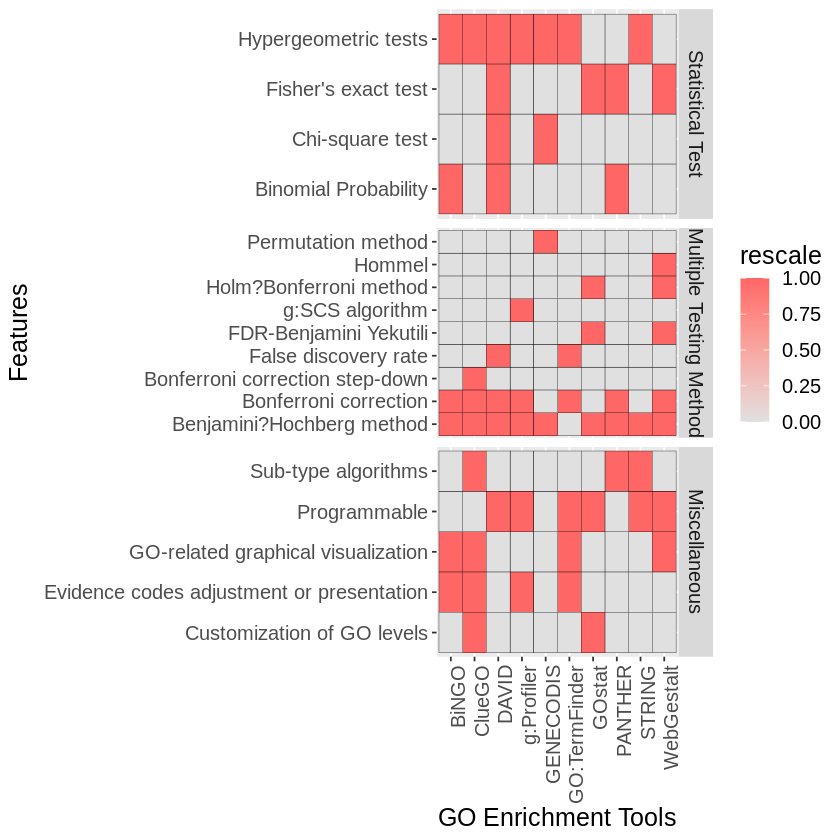

In [14]:
# Characteristics (Working in local rsutudio)
df1.m <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Characteristics.txt")
df1.m$type <- factor(df1.m$type, levels = c("Statistical Test","Multiple Testing Method","Miscellaneous"))
ggplot(df1.m, aes(x=Database, y=variable)) +
  geom_tile(aes(fill = rescale), colour = "black") +
  scale_fill_gradient(low = "#E0E0E0", high = "#FF6666") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(colors = "") +theme(axis.text=element_text(size=12)) +
  ylab("Features") +
  xlab("GO Enrichment Tools") +
  facet_grid(type ~ .,scales = "free") + 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15),
        axis.text.x = element_text(angle=90, hjust=1)) 



#Plot Frequency (Sig and Non. Sig)

`summarise()` regrouping output by 'Database', 'Group', 'Type' (override with `.groups` argument)



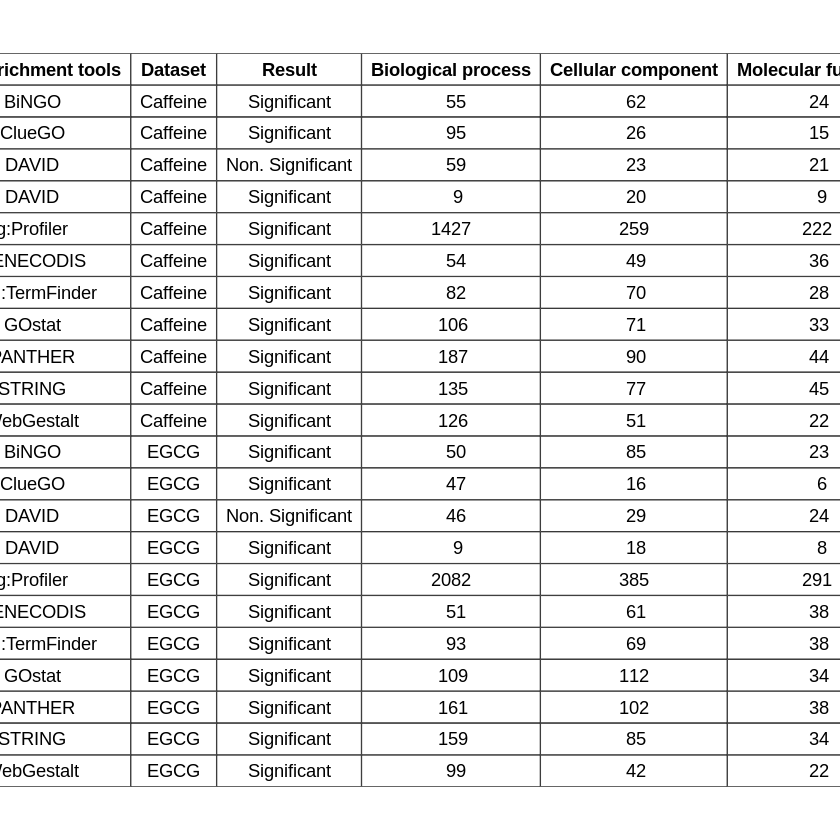

In [31]:
# Plot Frequency
df_01$Condition <- ifelse(df_01$FDR < 0.05,"Significant","Non. Significant")

##Count and Plot

##Count
count <- df_01[,-6] %>% unique() %>% group_by(Database,Group,Type,Condition) %>% dplyr::summarise(count=n()) %>% as.data.frame()
resh <- reshape(count, idvar = c("Database","Group","Condition"), timevar = "Type", direction = "wide")
resh.01 <-resh[order(resh$Group),]
names(resh.01) <- c("GO enrichment tools",
                    "Dataset",
                    "Result",
                    "Biological process",
                    "Cellular component",
                    "Molecular function")

ggtexttable(resh.01, rows = NULL, theme = ttheme("classic"))


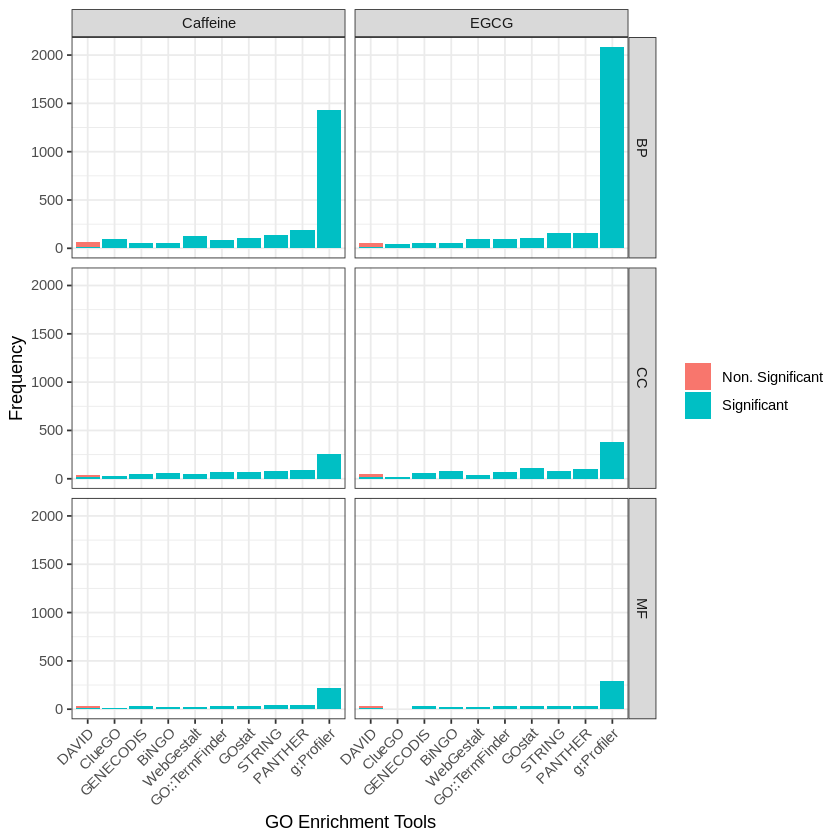

In [32]:
##Plot
ggplot(data=count, aes(x=reorder(Database,count), y=count, fill=Condition)) +
  geom_bar(stat="identity") +
  theme_bw() +
  facet_grid(vars(Type), vars(Group)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(fill = "") +
  xlab("GO Enrichment Tools") +
  ylab("Frequency")


#Plot Frequency of BP, MF, CC between Caffeine and EGCG (Sig. Only)

In [33]:
round_df <- function(df, digits, rf="round") {
  
  if(  missing(df) ){  
    stop("df not set", call. = F) 
  }else if(!is.data.frame(df)){
    stop("df must be a dataframe", call.=F)
  }
  
  if(missing(digits)){
    digits <- 0
  }else if(!is.numeric( digits )){
    stop( "'digits' must be numeric", call.=F)
  }else if(length(digits)!=1){
    stop("length of 'digits' must be 1", call.=F)
  }else if(! digits > -10 | ! digits <= 10){
    stop("'digits' must be a number between -10 and 10", call.=F)
  }
  
  if(!is.character( rf )){
    stop( "'rf' must be character", call.=F)
  }else if(length(rf)!=1){
    stop("Length of 'rf' must be 1", call.=F)
  }else if(! rf %in% c('round', 'ceiling', 'floor', 'trunc', 'signif') ){ 
  stop("'rf' must be equal to 'round', 'ceiling', 'trunc', 'floor' or 'signif' ", call. = F) 
  }
  
  numeric_columns <- sapply(df, class) == 'numeric'
  
  if(rf=="round"){
  
  df[numeric_columns] <-  round(df[numeric_columns], digits)
  
  }else if(rf=="ceiling"){
    
    df[numeric_columns] <-  ceiling(df[numeric_columns])
    
  }else if(rf=="floor"){
    
    df[numeric_columns] <-  floor(df[numeric_columns])
    
  }else if(rf=="trunc"){
    
    df[numeric_columns] <-  ceiling(df[numeric_columns])
    
  }else if(rf=="signif"){
    
    df[numeric_columns] <-  signif(df[numeric_columns], digits)
    
  }
  
  df
}

`summarise()` regrouping output by 'Database', 'Group' (override with `.groups` argument)



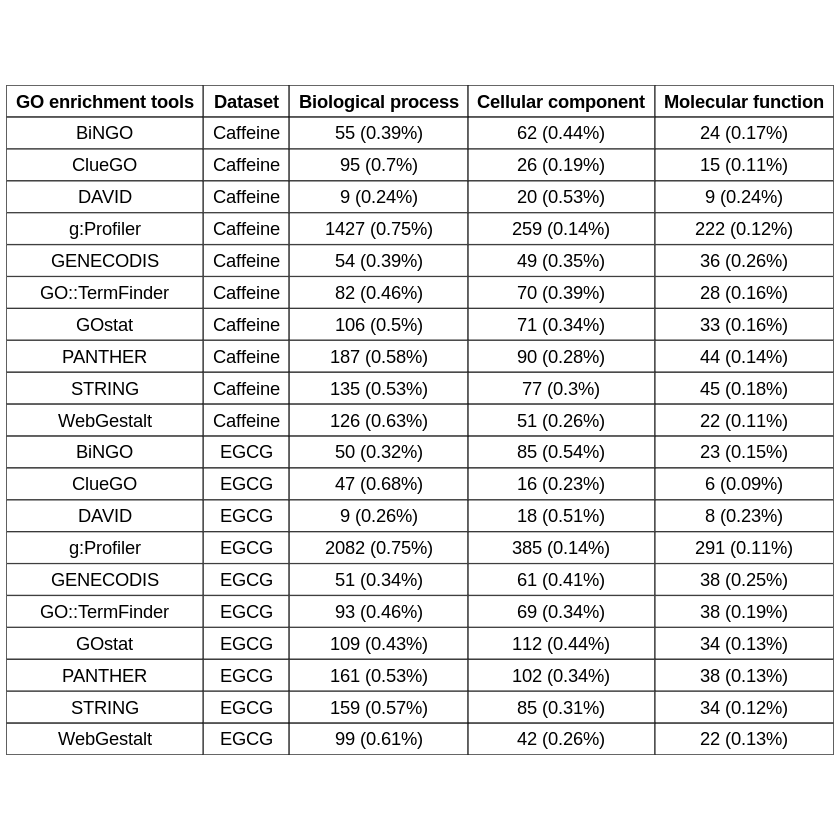

In [34]:
count_02 <-df_01[,-6] %>% unique() %>% filter(.,Condition == "Significant") %>% group_by(Database,Group,Type) %>% dplyr::summarise(count=n()) %>% as.data.frame() 
resh <- reshape(count_02, idvar = c("Database","Group"), timevar = "Type", direction = "wide")
resh.01 <-resh[order(resh$Group),]
names(resh.01) <- c("GO enrichment tools",
                    "Dataset",
                    "Biological process",
                    "Cellular component",
                    "Molecular function")

resh.02 <- cbind(resh.01[,c(1,2)], prop.table(as.matrix(resh.01[,-c(1,2)]), margin = 1))
resh.02[,c(3:5)] <- round_df(resh.02[,c(3:5)], digits=2)

all_non <- cbind(resh.01,resh.02)[,-c(6,7)] 
all_non$`Biological process` <- paste0(all_non$`Biological process`," ","(",all_non$`Biological process.1`,"%",")")
all_non$`Cellular component` <- paste0(all_non$`Cellular component`," ","(",all_non$`Cellular component.1`,"%",")")
all_non$`Molecular function` <- paste0(all_non$`Molecular function`," ","(",all_non$`Molecular function.1`,"%",")")

all_non.final <- all_non[,-c(6,7,8)]
#reshape(all_non.final, idvar = "GO enrichment tools", timevar = "Dataset", direction = "wide")
ggtexttable(all_non.final, rows = NULL, theme = ttheme("classic"))


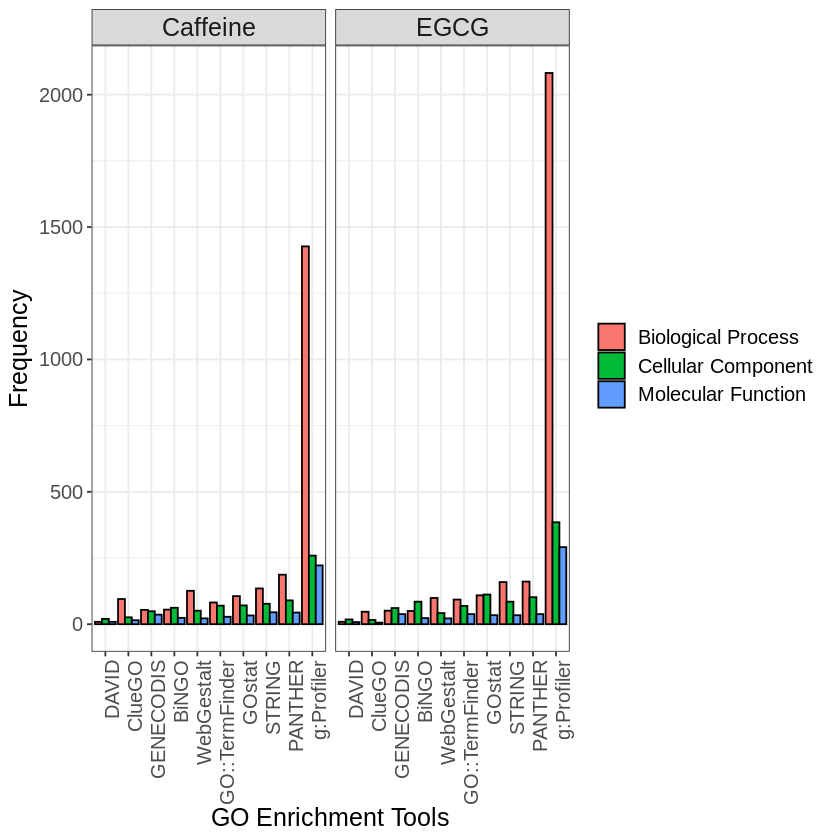

In [35]:

ggplot(data=count_02, aes(x=reorder(Database,count), y=count, fill=Type)) +
  geom_bar(stat="identity", color="black", position=position_dodge()) +
  theme_bw() +
  facet_grid(cols=vars(Group)) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(fill = "")+
  xlab("GO Enrichment Tools") +
  ylab("Frequency")+ 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15),
        axis.text.x = element_text(angle=90, hjust=1)) +
  scale_fill_discrete(name = "", labels = c("Biological Process",
                                                "Cellular Component",
                                                "Molecular Function"))

#GO proportion

In [38]:
chi <- df_01[,-6] %>% unique() %>% filter(.,FDR < 0.05) %>% dplyr::select(Database,Type,Group)  
chi_02 <- table(chi$Database,chi$Type,chi$Group) %>% as.data.frame()
chi_03 <- reshape(chi_02, idvar = c("Var1","Var3"), timevar = "Var2", direction = "wide") 
names(chi_03) <- c("Database","Dataset","BP","CC","MF")
chi_4 <- cbind(chi_03[,c(1,2)], prop.table(as.matrix(chi_03[,-c(1,2)]), margin = 1)) %>% melt(.)
head(chi_4)

Using Database, Dataset as id variables



,Database,Dataset,variable,value
,<fct>,<fct>,<fct>,<dbl>
1,BiNGO,Caffeine,BP,0.3900709
2,ClueGO,Caffeine,BP,0.6985294
3,DAVID,Caffeine,BP,0.2368421
4,g:Profiler,Caffeine,BP,0.7479036
5,GENECODIS,Caffeine,BP,0.3884892
6,GO::TermFinder,Caffeine,BP,0.4555556


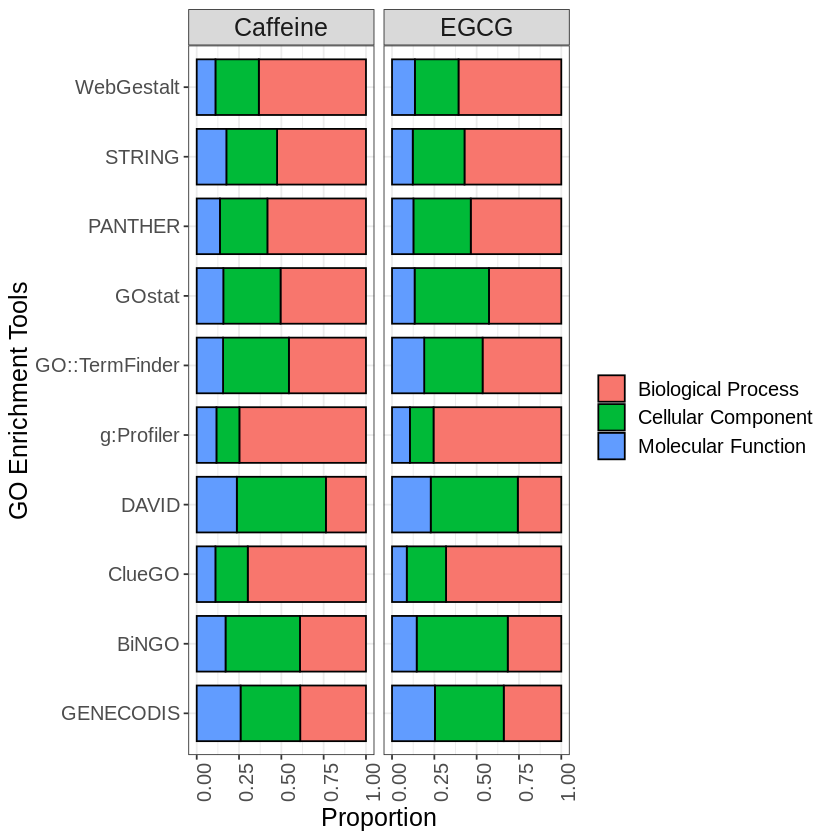

In [39]:
ggplot(data=chi_4, aes(x=reorder(Database,-value), y=value, fill=variable)) +
  geom_bar(stat="identity",color = "black",width=0.8) +
  theme_bw() + ylab("Proportion") + xlab("GO Enrichment Tools")  + guides(fill=guide_legend(title="")) + 
  coord_flip()+
  facet_grid(. ~ Dataset) + 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15),
        axis.text.x = element_text(angle=90, hjust=1)) +
  scale_fill_discrete(name = "", labels = c("Biological Process",
                                            "Cellular Component",
                                            "Molecular Function"))

## Chi-square Test

### Test between and within group

In [47]:
# Chitest between
for (i in unique(chi_03$Database) %>% unlist()) {
  print(i)
  chi_05 <- chi_03 %>% filter(.,Database == i) %>% dplyr::select(-Dataset)
  chi_06 <- chi_05[,-c(1)]
  x <- chisq.test(chi_06)  
  print(x$p.value)
}


[1] "BiNGO"
[1] 0.2344726
[1] "ClueGO"
[1] 0.7284904
[1] "DAVID"
[1] 0.9797733
[1] "g:Profiler"
[1] 0.4965945
[1] "GENECODIS"
[1] 0.5970023
[1] "GO::TermFinder"
[1] 0.5586768
[1] "GOstat"
[1] 0.08484124
[1] "PANTHER"
[1] 0.287791
[1] "STRING"
[1] 0.2158529
[1] "WebGestalt"
[1] 0.7648467


In [48]:
# Chitest within
for (i in unique(chi_03$Dataset) %>% unlist()) {
  print(i)
  chi_05 <- chi_03 %>% filter(.,Dataset == i) %>% dplyr::select(-Database)
  chi_06 <- chi_05[,-c(1)]
  x <- chisq.test(chi_06)  
  print(x$statistic)
  print(x$p.value)}



[1] "Caffeine"
X-squared 
 296.1834 
[1] 2.932644e-52
[1] "EGCG"


Warning message in chisq.test(chi_06):
“Chi-squared approximation may be incorrect”


X-squared 
 468.8059 
[1] 3.709202e-88


In [49]:
#pairwise (Within Group)
for (i in unique(chi_03$Dataset) %>% unlist()) {
  print(i)
  chi_05 <- chi_03 %>% filter(.,Dataset == i) %>% dplyr::select(-Dataset)
  chi_06 <- chi_05[,-c(1)]
  x <- chisq.test(chi_06)  
  print(x$statistic)
  print(x$p.value)}


[1] "Caffeine"
X-squared 
 296.1834 
[1] 2.932644e-52
[1] "EGCG"


Warning message in chisq.test(chi_06):
“Chi-squared approximation may be incorrect”


X-squared 
 468.8059 
[1] 3.709202e-88


### Heatmap For Pairwise Comparison

#### EGCG dataset

In [103]:

x.01 <- chi_03 %>% filter(.,Dataset != "Caffeine") %>% dplyr::select(-Dataset)
x.02 <- t(x.01[,-1]) %>% as.data.frame
df_name <- x.01[1] %>% unlist()
names(x.02) <- df_name
chi_03
x.02

,Database,Dataset,BP,CC,MF
,<fct>,<fct>,<int>,<int>,<int>
1,BiNGO,Caffeine,55,62,24
2,ClueGO,Caffeine,95,26,15
3,DAVID,Caffeine,9,20,9
4,g:Profiler,Caffeine,1427,259,222
5,GENECODIS,Caffeine,54,49,36
6,GO::TermFinder,Caffeine,82,70,28
7,GOstat,Caffeine,106,71,33
8,PANTHER,Caffeine,187,90,44
9,STRING,Caffeine,135,77,45


,BiNGO,ClueGO,DAVID,g:Profiler,GENECODIS,GO::TermFinder,GOstat,PANTHER,STRING,WebGestalt
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
BP,50,47,9,2082,51,93,109,161,159,99
CC,85,16,18,385,61,69,112,102,85,42
MF,23,6,8,291,38,38,34,38,34,22


In [104]:
# initialization
out_list <- list()
column <- 1
# cycle for storing kappa2's output structure
for (i in 1:(ncol(x.02)-1)){
  for (j in (i+1):ncol(x.02)){
    x <- chisq.test(x.02[,c(i,j)])
    out_list[[column]] <- x$p.value
    # renaming the elements
    names(out_list)[column] <- paste0(colnames(x.02[i]), "_", colnames(x.02[j]))
    column <- column + 1
  }
}

res.eg <- do.call(rbind,out_list) %>% as.data.frame()
res.eg$data <- rownames(res.eg)
res.eg.1 <- splitstackshape::cSplit(res.eg, "data", "_")
res.eg.1$type <- "EGCG Dataset"

res.eg.1

Warning message in chisq.test(x.02[, c(i, j)]):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(x.02[, c(i, j)]):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(x.02[, c(i, j)]):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(x.02[, c(i, j)]):
“Chi-squared approximation may be incorrect”


V1,data_1,data_2,type
<dbl>,<fct>,<fct>,<chr>
1.893928e-06,BiNGO,ClueGO,EGCG Dataset
4.518455e-01,BiNGO,DAVID,EGCG Dataset
1.077004e-41,BiNGO,g:Profiler,EGCG Dataset
2.422356e-02,BiNGO,GENECODIS,EGCG Dataset
1.147743e-03,BiNGO,GO::TermFinder,EGCG Dataset
7.344658e-02,BiNGO,GOstat,EGCG Dataset
2.584564e-05,BiNGO,PANTHER,EGCG Dataset
8.035760e-07,BiNGO,STRING,EGCG Dataset
2.238119e-07,BiNGO,WebGestalt,EGCG Dataset



#### Caffeine dataset

In [105]:
x.01 <- chi_03 %>% filter(.,Dataset != "EGCG") %>% dplyr::select(-Dataset)
x.02 <- t(x.01[,-1]) %>% as.data.frame
df_name <- x.01[1] %>% unlist()
names(x.02) <- df_name


In [106]:
# initialization
out_list <- list()
column <- 1
# cycle for storing kappa2's output structure
for (i in 1:(ncol(x.02)-1)){
  for (j in (i+1):ncol(x.02)){
    x <- chisq.test(x.02[,c(i,j)])
    out_list[[column]] <- x$p.value
    # renaming the elements
    names(out_list)[column] <- paste0(colnames(x.02[i]), "_", colnames(x.02[j]))
    column <- column + 1
  }
}

res.caf <- do.call(rbind,out_list) %>% as.data.frame()
res.caf$data <- rownames(res.caf)
res.caf.1 <- splitstackshape::cSplit(res.caf, "data", "_")
res.caf.1$type <- "Caffeine Dataset"



Warning message in chisq.test(x.02[, c(i, j)]):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(x.02[, c(i, j)]):
“Chi-squared approximation may be incorrect”


In [107]:
res.all <- rbind(res.caf.1,res.eg.1)
res.all$data_2 <- gsub(".[0-9]", "", res.all$data_2)

res.all$sig <- ifelse(res.all$V1 < 0.001,"***",
                      ifelse(res.all$V1 < 0.01,"**",
                             ifelse(res.all$V1 < 0.05,"*","ns")))


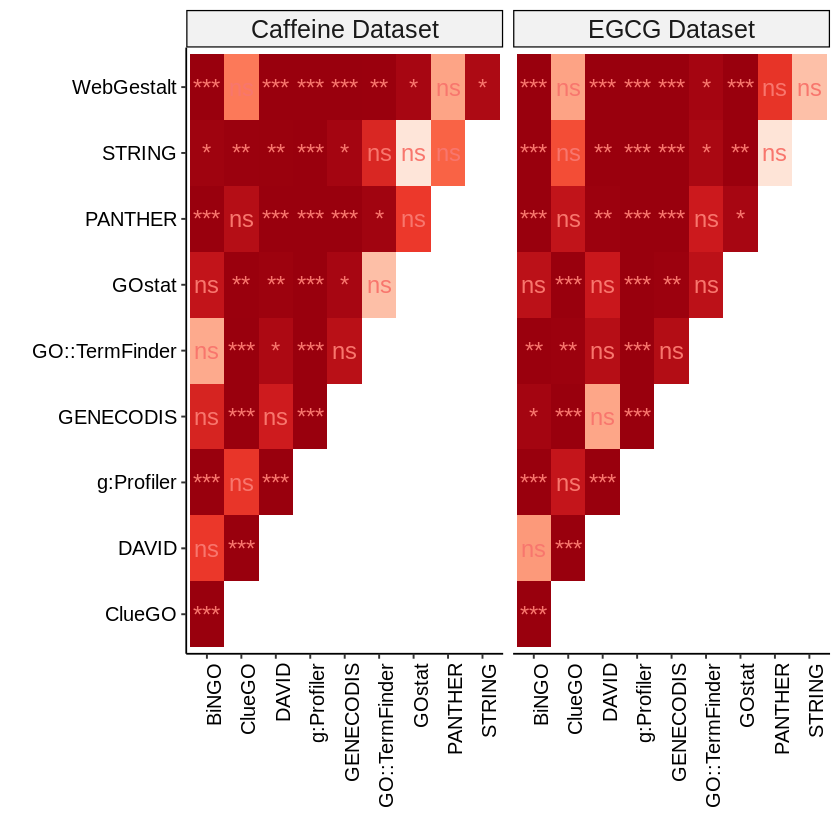

In [108]:
ggplot(data = res.all, aes(x = data_1, y = data_2)) +
  geom_tile(aes(fill=V1))+
  facet_grid(cols=vars(type)) + 
  theme_pubr() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  geom_text(aes(label=sig,color="white"),cex=5)+
  theme(legend.position="none") +
  scale_fill_distiller(palette = "Reds") +
  xlab("") +
  ylab("") + 
  theme(strip.text.x = element_text(size = 15)) 

#Compare the number of Gene in GO terms

In [60]:
all <- df_01 %>% filter(.,FDR<0.05) %>% setnames("Group","Dataset")
head(all)

GOID,Description,FDR,Database,Type,Genes,Enrichment,Dataset,Condition
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GO:0008301,"DNA binding, bending",0.0499,STRING,MF,HMGA2,All (Up vs. Down),EGCG,Significant
GO:0008301,"DNA binding, bending",0.0499,STRING,MF,HMGB1,All (Up vs. Down),EGCG,Significant
GO:0005544,calcium-dependent phospholipid binding,0.0499,GOstat,MF,ANXA4,All (Up vs. Down),EGCG,Significant
GO:0005544,calcium-dependent phospholipid binding,0.0499,GOstat,MF,ANXA11,All (Up vs. Down),EGCG,Significant
GO:0035986,senescence-associated heterochromatin focus assembly,0.0499,GO::TermFinder,BP,HMGA2,All (Up vs. Down),EGCG,Significant
GO:0035986,senescence-associated heterochromatin focus assembly,0.0499,GO::TermFinder,BP,HMGA1,All (Up vs. Down),EGCG,Significant


##EGCG

In [62]:
gene_duplicate <- all %>% filter(Dataset == "EGCG") %>%  
  dplyr::select(GOID,Database,Dataset) %>% unique()
gene_duplicate

#dup = 486
gene_duplicate.list <- table(gene_duplicate$GOID) %>% as.data.frame() %>% filter(.,Freq > 1) %>% dplyr::select(Var1) %>% unlist() 

# dup.01 = 359
Tgene_min <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "EGCG") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.min(count)) 

# dup.01 = 359
Tgene_max <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "EGCG") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.max(count)) 


# equal = 127
Tgene_equal <- Tgene_max$count - Tgene_min$count %>% as.data.frame()
Tgene_equal$GOID <- Tgene_max$GOID
names(Tgene_equal) <- c("range","GOID")
equal_gene <- Tgene_equal %>% filter(.,range == 0) %>% dplyr::select(GOID) %>% unlist()


# dup.01 = 359
Tgene_min <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "EGCG") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.min(count)) %>% as.data.frame() %>% filter(.,!GOID %in% equal_gene)  

 dup.01 = 359
Tgene_max <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "EGCG") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.max(count)) %>% as.data.frame() %>% filter(.,!GOID %in% equal_gene)



count.max <- table(Tgene_max$Database,Tgene_max$Dataset,Tgene_max$Type) %>% as.data.frame()
count.max$con <- "Maximum"
count.min <- table(Tgene_min$Database,Tgene_min$Dataset,Tgene_min$Type) %>% as.data.frame()
count.min$con <- "Minimum" 

min_max.EGCG <- rbind(count.max,count.min)


GOID,Database,Dataset
<chr>,<chr>,<chr>
GO:0008301,STRING,EGCG
GO:0005544,GOstat,EGCG
GO:0035986,GO::TermFinder,EGCG
GO:0042886,GO::TermFinder,EGCG
GO:0030163,g:Profiler,EGCG
GO:0050920,g:Profiler,EGCG
GO:0031625,GENECODIS,EGCG
GO:1905114,g:Profiler,EGCG
GO:0044428,BiNGO,EGCG


`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)



##Caffeine

In [63]:
gene_duplicate <- all %>% filter(Dataset == "Caffeine") %>%  
  dplyr::select(GOID,Database,Dataset) %>% unique()
gene_duplicate

#dup = 486
gene_duplicate.list <- table(gene_duplicate$GOID) %>% as.data.frame() %>% filter(.,Freq > 1) %>% dplyr::select(Var1) %>% unlist() 

# dup.01 = 359
Tgene_min <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "Caffeine") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.min(count)) 

# dup.01 = 359
Tgene_max <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "Caffeine") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.max(count)) 


# equal = 127
Tgene_equal <- Tgene_max$count - Tgene_min$count %>% as.data.frame()
Tgene_equal$GOID <- Tgene_max$GOID
names(Tgene_equal) <- c("range","GOID")
equal_gene <- Tgene_equal %>% filter(.,range == 0) %>% dplyr::select(GOID) %>% unlist()


# dup.01 = 359
Tgene_min <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "Caffeine") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.min(count)) %>% as.data.frame() %>% filter(.,!GOID %in% equal_gene)  

 dup.01 = 359
Tgene_max <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "Caffeine") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.max(count)) %>% as.data.frame() %>% filter(.,!GOID %in% equal_gene)



count.max <- table(Tgene_max$Database,Tgene_max$Dataset,Tgene_max$Type) %>% as.data.frame()
count.max$con <- "Maximum"
count.min <- table(Tgene_min$Database,Tgene_min$Dataset,Tgene_min$Type) %>% as.data.frame()
count.min$con <- "Minimum" 

min_max.Caffeine <- rbind(count.max,count.min)


GOID,Database,Dataset
<chr>,<chr>,<chr>
GO:0000184,DAVID,Caffeine
GO:0000502,DAVID,Caffeine
GO:0000785,DAVID,Caffeine
GO:0001895,DAVID,Caffeine
GO:0003723,DAVID,Caffeine
GO:0003735,DAVID,Caffeine
GO:0005200,DAVID,Caffeine
GO:0005515,DAVID,Caffeine
GO:0005654,DAVID,Caffeine


`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)



## Combine dataframe and plot

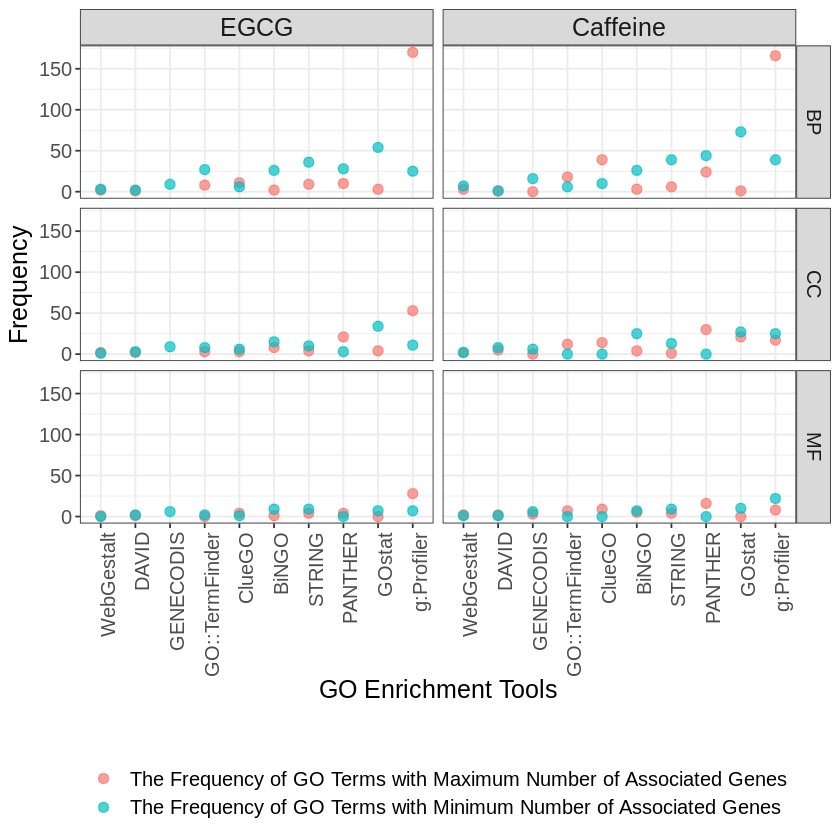

In [64]:

min_max.all <- rbind(min_max.EGCG,min_max.Caffeine)  %>% group_by(Var2,Var3,con) %>%
  mutate(my_ranks = order(order(Freq, decreasing=TRUE)))

min_max.all$con_02 <- ifelse(min_max.all$con == "Maximum",
                             "The Frequency of GO Terms with Maximum Number of Associated Genes",
                             "The Frequency of GO Terms with Minimum Number of Associated Genes")

ggplot(data=min_max.all, aes(x=reorder(Var1,Freq), y=Freq, color=con_02)) +
  geom_point(size = 2.5,alpha = 0.7) +
  theme_bw() +
  facet_grid(vars(Var3),vars(Var2)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(fill = "") +
  xlab("GO Enrichment Tools") +
  ylab("Frequency") +
  labs(color="") +
  theme(legend.position="bottom", legend.direction="vertical") + 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15),
        axis.text.x = element_text(angle=90, hjust=1))



##Test Correlation

`geom_smooth()` using formula 'y ~ x'



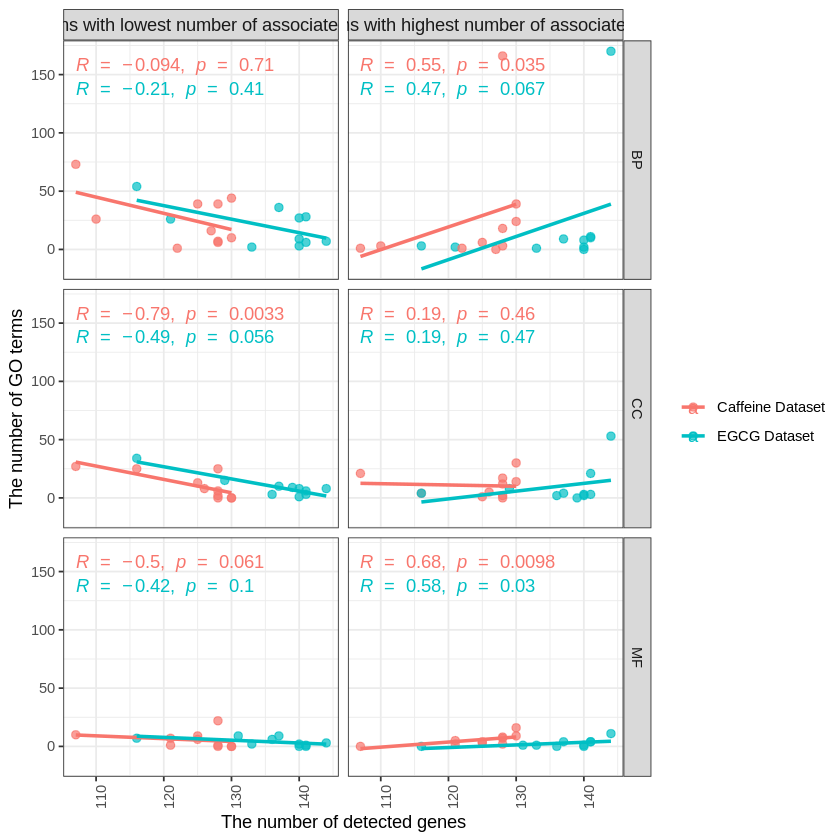

In [65]:

df <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Correlation-GOterm-Input.txt") %>% melt(.,id.vars=c("dataset","Input","Tools","Type"))


ggplot(df,aes(x=Input,y=value, color=dataset)) +
  geom_point(size = 2,alpha = 0.7) +
  theme_bw() +
  facet_grid(vars(Type),vars(variable)) +
  stat_cor(method="kendall") +
  xlab("The number of detected genes") +
  ylab("The number of GO terms") +
  labs(color="") +
  geom_smooth(method='lm',se = FALSE) + 
  theme(strip.text.x = element_text(size = 11))+
  theme(text = element_text(size=11),
        axis.text.x = element_text(angle=90, hjust=1))



`summarise()` regrouping output by 'Database', 'Dataset' (override with `.groups` argument)



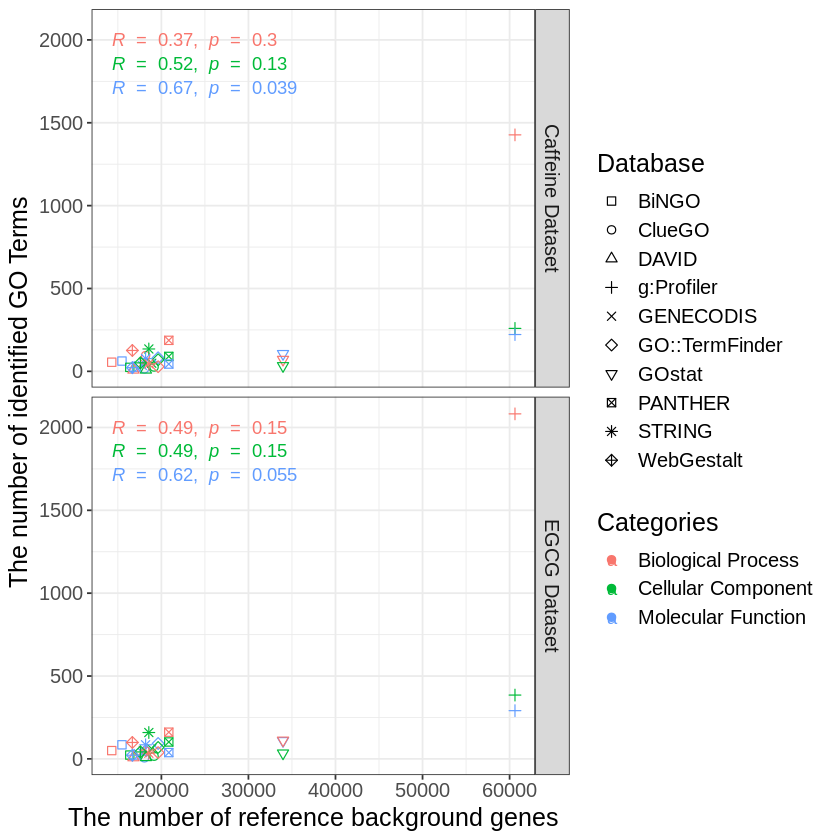

In [66]:
df <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Reference-Count.txt") %>% as.data.frame()
df.01 <- df[with(df, order(Database,Dataset)), ]
df.all <- all[,-6] %>% unique() %>% group_by(Database,Dataset,Type) %>% 
  dplyr::summarise(CNT=n()) %>% as.data.frame() 
df.all.01 <- df.all[with(df.all, order(Database,Dataset)), ]



c.df <- cbind(df.01,df.all.01)[,-c(5,6,7)]


ggplot(c.df,aes(back,CNT,color=Categories)) +
  geom_point(aes(shape=Database),size=2) + 
  scale_shape_manual(values=seq(0,10)) +
  facet_grid(rows=vars(Dataset))  +
  theme_bw() +
  stat_cor(method="spearman") +
  xlab("The number of reference background genes") +
  ylab("The number of identified GO Terms")+ 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15))


## Comparsion of g:Profiler and BiNGO